In [1]:
%load_ext autoreload
%autoreload 2

import time
from functools import partial

import network
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

from numba import jit, objmode, types
from numba import int32, uint32, float32, bool

# Aufgabe 2
Ermitteln der Perkolationsschwelle $p_c$ für verschiedene $L$ mit jeweils 50 berechnungen und dann Mittelung dieser Werte.
Es wird mit $L=8=2^3$ gestartet und dann so lange verdoppelt wie der PC damit klarkommt.

Um die Perkolationsschwelle für ein Gitter zu bestimmen wird bei einem geeigneten $p_{min}$ gestartet und so lange $2\%$ addiert bis ein Cluster perkoliert.
Dann wird wieder ein Schritt zurückgegangen bei $p$ und die Schrittweite gefünftelt (also $0,4\%$). Nun wird wieder so lange $p$ erhöht mit der neuen Schrittweite, bis ein Cluster perkoliert. Das Fünfteln wird fünfmal vorgenommen, sodass theoretisch eine Genauigkeit von $\pm0,00064\%$ entsteht.

Im ersten Codeblock befindet sich der Algorithmus zur Berechnung der Perkolationsschwelle.

In [3]:
@jit()
def to_str(num):
    return f'{int(num * 1e6)}'

@jit(float32(int32, float32, float32[:])) # annotate to tell numba to compile (argument is the method signature, its optional but can help prevent issues)
def calc_pc_once2(L, min_p=0.5, info=None):
    if info is None: info = np.zeros(2, dtype=np.float32)
    step_step = 5.0 # factor to decrease step by
    step = 0.02 * step_step # amount to increase p by each iteration (increased, because it's decreased at the start)
    p = min_p + step # start p ((increased, because it's decreased at the start))
    for i in range(5): # divide step 5 times in total
        p -= step # go back a step because it might have percolated
        step /= step_step # lower resolution and search again, start with 0.02 -> 0.004 -> 0.0008 -> 0.00016 -> 0.000032 -> 0.0000064
        percolated = False
        while not percolated:
            n = network.Network(int(L), int(L), p)
            n.hoshen_kopelman()
            info[1] += 1 # total number of grids
            if n.is_percolating():
                if i == 0 and p < min_p + step:
                    raise Exception("starting p was set to high")
                percolated = True # search again with lower resolution
            else:
                p += step # not percolating, try higher p
    return p

# finds smallest p where a grid of size L perculates with multiple runs and averaging the result
@jit(float32(int32, float32, int32, float32[:]), fastmath=True)
def calc_pc(L, min_p=0.50, amount=50, fail=None):
    pcs = np.zeros(amount)
    for i in range(amount):
        pcs[i] = calc_pc_once2(L, min_p, fail)
    #print(pcs)
    return np.average(pcs[pcs > 0])

def do_ex(L, min_p=0.50, amount=50):
    info = np.zeros(2, dtype=np.float32)
    t = time.perf_counter()
    pc = calc_pc(L, min_p, amount, info)
    print(f'Size {L} took {round(time.perf_counter() - t, 4)} seconds for a total of {info[1]} grids and min_p {min_p}')
    return pc

Nun wird $p_c$ für $L=2^3$ bis $L=2^{11}$ berechnet.

In [4]:

exp = np.array(range(3, 11 + 1))
pc = np.zeros(len(exp))
for i in exp:
    pc[i-3] = do_ex(2**i, min_p=0.5 if i >= 6 else (i-1)*0.1)


Size 8 took 0.0086 seconds for a total of 2472.0 grids and min_p 0.2
Size 16 took 0.0098 seconds for a total of 1640.0 grids and min_p 0.30000000000000004
Size 32 took 0.0182 seconds for a total of 1198.0 grids and min_p 0.4
Size 64 took 0.0455 seconds for a total of 931.0 grids and min_p 0.5
Size 128 took 0.2084 seconds for a total of 1151.0 grids and min_p 0.5
Size 256 took 0.7324 seconds for a total of 1046.0 grids and min_p 0.5
Size 512 took 4.6149 seconds for a total of 1142.0 grids and min_p 0.5
Size 1024 took 19.0641 seconds for a total of 1025.0 grids and min_p 0.5
Size 2048 took 76.3135 seconds for a total of 1018.0 grids and min_p 0.5


Definiere nun eine Funktion die automatisch die nächst größere Ordnung berechnet.

In [5]:
old_exp = exp
old_pc = pc

def reset():
    exp = old_exp
    pc = old_pc

def do_next():
    global exp, pc
    exp = np.array([*exp, exp[-1] + 1])
    pc = np.array([*pc, 0])
    pc[-1] = do_ex(2**exp[-1], min_p=0.5)

Berechnungen für $L>2^{11}$ separat wegen langer Laufzeiten.

In [6]:
do_next() # 4096

Size 4096 took 332.1357 seconds for a total of 1100.0 grids and min_p 0.5


In [7]:
do_next() # 8192

Size 8192 took 1285.7467 seconds for a total of 1047.0 grids and min_p 0.5


In [8]:
do_next()

Size 16384 took 4713.0955 seconds for a total of 1051.0 grids and min_p 0.5


[0.48205698 0.55661571 0.58044416 0.58586049 0.58675903 0.58968449
 0.59031677 0.59217983 0.59228289 0.59245825 0.59267777 0.59266752]


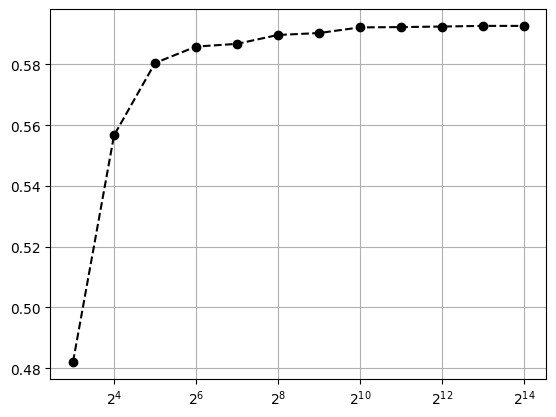

In [9]:
print(pc)
fig, ax = plt.subplots()
ax.plot(2**exp, pc, 'ok--')
ax.set_xscale('log', base=2)
plt.grid(True)

Damit lässt sich die Perkolationsschwelle auf $59,27\% < p_c < 59,3\%$ einschränken.